In [2]:
from functions import *
import pandas as pd
import seaborn as sns
import statistics
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, median_absolute_error, mean_squared_error
%matplotlib inline
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import numpy as np

SAMPLE = 5000 # Training sample (Used: 5000, 20000)
GRANULARITY = 15000 # Only work with the last X rows of data sets (Used: 15000, 220000)
REMOVE_OUTLIERS = False # False, or Number for whisker, 3 = only remove extreme outliers
ONLY_TRANSPARENT = False # False, or True, filter for only TSP blocks
SAVE_FIGURES = False
DPI = 300

blocks_HDD = pd.read_csv("./raw_data/HDD/eval_all_blocks.csv", names=["BLOCK", "BLOCK_NS"])
blocks_SSD = pd.read_csv("./raw_data/SSD/eval_all_blocks.csv", names=["BLOCK", "BLOCK_NS"])

blocks_info = pd.read_csv("./data/enhanced_block.csv", names=["BLOCK", "SIZE", "VERSION", "numberTX", "numberVin", "numberVout", "numberJoinSplit", "numbervShieldedSpend", "numbervShieldedOutput"])

# Remove extreme outliers
if REMOVE_OUTLIERS:
    old_count_hdd = blocks_HDD['BLOCK'].count()
    old_count_ssd = blocks_SSD['BLOCK'].count()
    blocks_HDD = subset_by_iqr(blocks_HDD, 'BLOCK_NS', whisker_width=REMOVE_OUTLIERS) 
    blocks_SSD = subset_by_iqr(blocks_SSD, 'BLOCK_NS', whisker_width=REMOVE_OUTLIERS)
    print('Outliers: {} removed for HDD and {} removed for SSD'.format(old_count_hdd - blocks_HDD['BLOCK'].count(), old_count_ssd - blocks_SSD['BLOCK'].count()))

# Merge Data
blocks = blocks_SSD.merge(blocks_HDD, how='inner', left_on="BLOCK", right_on="BLOCK", suffixes=('_SSD', '_HDD'))
blocks = blocks.merge(blocks_info, how='inner', left_on="BLOCK", right_on="BLOCK")
onlyContainingTransparent = blocks.loc[(blocks['numberJoinSplit'] == 0) & (blocks['numbervShieldedSpend'] == 0) & (blocks['numbervShieldedOutput'] == 0)]

if GRANULARITY:
    blocks = blocks.tail(GRANULARITY)

if ONLY_TRANSPARENT:
    blocks = blocks[blocks['BLOCK'].isin(onlyContainingTransparent['BLOCK'])]

print('Blocks ' + blocks.iloc[0]['BLOCK'] + ' till ... ' + blocks.iloc[-1]['BLOCK'])

Blocks 0000000000b3f611c39a11469981884bd0b34c9954c51c80a6c5d667729a88ec till ... 00000000009e4f8f692d035202d57fcf3d8e62c1dd9a5802daa4f82794436b51


In [3]:
def calculate_error(real, predicted):
    print('MEAN aboslute error: ', mean_absolute_error(real, predicted))
    print('MEAN relative (%) error: ', mean_absolute_error_percent(real, predicted))
    print('Median aboslute error: ', median_absolute_error(real, predicted))
    print('Median rleative (%) error: ', median_absolute_error_percent(real, predicted))
    print('Mean Squared error:', mean_squared_error(real, predicted))
    print('R2: ', r2_score(real, predicted))    

In [4]:
def model(meNS_Byte, estimates, postfix):
    estimates['KB_' + postfix] = meNS_Byte * estimates["SIZE"]
    calculate_error(estimates["BLOCK_NS_" + postfix], estimates['KB_' + postfix])

In [5]:
# gervaivs' constant
gervais = blocks.copy(deep=True)
meNS_Byte = 379.6

print('gervaivs KB...')
model(meNS_Byte, gervais, 'SSD')

gervaivs KB...
MEAN aboslute error:  11917311.536906667
MEAN relative (%) error:  86.23030854987917
Median aboslute error:  2904401.6
Median rleative (%) error:  71.43141276052475
Mean Squared error: 2154943761595602.2
R2:  0.02035813553981969


In [6]:
def model_improved(kI, kS, kO, kJ, k, estimates, postfix):
    estimates['KV_' + postfix] = estimates['numbervShieldedSpend'] * kS + estimates['numbervShieldedOutput'] * kO + estimates['numberVin'] * kI + estimates['numberJoinSplit'] * kJ + k
    calculate_error(estimates["BLOCK_NS_" + postfix], estimates['KV_' + postfix])

<Figure size 432x288 with 0 Axes>

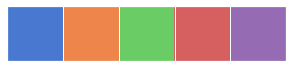

In [7]:
# Prepare plots
color = "muted"
sns.set(style="darkgrid", palette=color, color_codes=True)
sns.despine(left=True)
plt.rcParams['figure.figsize'] = [10/2.54, 8/2.54]
color = sns.color_palette(color, 5)
sns.palplot(sns.color_palette(color, 5))
color_primary = color[0]
color_kb = color[2]
color_r2 = color[3]
color_kv = color[1]
color_gv = color[4]

In [8]:
# Now we use linear regression to better predict the coefficients 
estimates_reg = blocks.copy(deep=True)
test_size = SAMPLE / estimates_reg['BLOCK'].count()
X_train, X_test = train_test_split(estimates_reg, train_size=test_size, random_state=42)
print('Test Blocks: ' + str(X_test['BLOCK'].count()))
print('Train Blocks: ' + str(X_train['BLOCK'].count()))

regr_kb_hdd = LinearRegression().fit(X_train[["SIZE"]], X_train['BLOCK_NS_HDD'])
X_test['KB_HDD'] = regr_kb_hdd.predict(X_test[["SIZE"]])
print('LR KB_HDD...')
print('Coefficients: \n', regr_kb_hdd.coef_)
print('Intercept: \n', regr_kb_hdd.intercept_)
calculate_error(X_test['BLOCK_NS_HDD'], X_test['KB_HDD'])

regr_kb_ssd = LinearRegression().fit(X_train[["SIZE"]], X_train['BLOCK_NS_SSD'])
X_test['KB_SSD'] = regr_kb_ssd.predict(X_test[["SIZE"]])
print('LR KB_SSD...')
print('Coefficients: \n', regr_kb_ssd.coef_)
print('Intercept: \n', regr_kb_ssd.intercept_)
calculate_error(X_test['BLOCK_NS_SSD'], X_test['KB_SSD'])

regr_kv_hdd = LinearRegression().fit(X_train[["numberVin", "numberJoinSplit", "numbervShieldedSpend", "numbervShieldedOutput"]], X_train['BLOCK_NS_HDD'])
X_test['KV_HDD'] = regr_kv_hdd.predict(X_test[["numberVin", "numberJoinSplit", "numbervShieldedSpend", "numbervShieldedOutput"]])
print('LR KV_HDD...')
print('Coefficients: \n', regr_kv_hdd.coef_)
print('Intercept: \n', regr_kv_hdd.intercept_)
calculate_error(X_test['BLOCK_NS_HDD'], X_test['KV_HDD'])

regr_kv_ssd = LinearRegression().fit(X_train[["numberVin", "numberJoinSplit", "numbervShieldedSpend", "numbervShieldedOutput"]], X_train['BLOCK_NS_SSD'])
X_test['KV_SSD'] = regr_kv_ssd.predict(X_test[["numberVin", "numberJoinSplit", "numbervShieldedSpend", "numbervShieldedOutput"]])
print('LR KV_SSD...')
print('Coefficients: \n', regr_kv_ssd.coef_)
print('Intercept: \n', regr_kv_ssd.intercept_)
calculate_error(X_test['BLOCK_NS_SSD'], X_test['KV_SSD'])

estimates_reg = X_test

Test Blocks: 10000
Train Blocks: 5000
LR KB_HDD...
Coefficients: 
 [4345.45401353]
Intercept: 
 8784760.27829269
MEAN aboslute error:  31195802.76923689
MEAN relative (%) error:  91.0796991027546
Median aboslute error:  15515904.872276403
Median rleative (%) error:  144.26891004780543
Mean Squared error: 2.1806452908653536e+16
R2:  0.09099044724326855
LR KB_SSD...
Coefficients: 
 [1717.37766995]
Intercept: 
 3584715.478678396
MEAN aboslute error:  10594982.491268016
MEAN relative (%) error:  78.33573672636803
Median aboslute error:  4824417.197199767
Median rleative (%) error:  118.68184986961296
Mean Squared error: 1417708149283514.0
R2:  0.25197443361807337
LR KV_HDD...
Coefficients: 
 [  246312.53207514 39760495.90448157  9862146.43768432 10999119.281232  ]
Intercept: 
 13209041.701389644
MEAN aboslute error:  22051200.67285564
MEAN relative (%) error:  64.38099179543188
Median aboslute error:  11673708.233464785
Median rleative (%) error:  108.54366386760192
Mean Squared error: 2.0

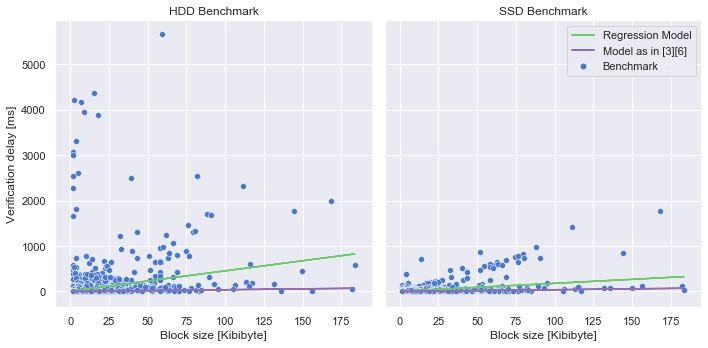

In [9]:
# Compare KB with NS and size
estimates_KB = estimates_reg.copy(deep=True)
estimates_KB = estimates_KB.rename(columns={'BLOCK_NS_HDD': 'HDD', 'BLOCK_NS_SSD': 'SSD'})
estimates_KB['KB_GER'] = gervais["KB_SSD"]

# melt data
gridplotdata = pd.melt(estimates_KB, id_vars=['KB_HDD', 'KB_SSD', 'KB_GER', 'BLOCK', 'SIZE'], value_vars=['HDD', 'SSD'])

gridplotdata["SIZE"] = gridplotdata["SIZE"] / 1024 # Convert to Kibibyte
gridplotdata["value"] = gridplotdata["value"] / 1000000 # Convert to ms
gridplotdata["KB_HDD"] = gridplotdata["KB_HDD"] / 1000000 # Convert to ms
gridplotdata["KB_GER"] = gridplotdata["KB_GER"] / 1000000 # Convert to ms
gridplotdata["KB_SSD"] = gridplotdata["KB_SSD"] / 1000000 # Convert to ms

grid = sns.FacetGrid(gridplotdata, col="variable", height=5, legend_out=False)
grid = grid.map(sns.scatterplot, "SIZE", "value", color=color_primary, edgecolors='w')
#grid.set(ylim=(-150, 6900), xlim=(-50, 1600))

ax1, ax2 = grid.axes[0]
ax1.plot(gridplotdata["SIZE"], gridplotdata["KB_HDD"], color=color_kb)
ax2.plot(gridplotdata["SIZE"], gridplotdata["KB_SSD"], color=color_kb)

ax1.plot(gridplotdata["SIZE"], gridplotdata["KB_GER"], color=color_gv)
ax2.plot(gridplotdata["SIZE"], gridplotdata["KB_GER"], color=color_gv)

from matplotlib.lines import Line2D
b_patch = Line2D([0], [0], color=color_kb, lw=2, label='Regression Model')
b2_patch = Line2D([0], [0], color=color_gv, lw=2, label='Model as in [3][6]')
g_patch = Line2D([0], [0], marker='o', color='#EDEDF4', label='Benchmark', markerfacecolor=color_primary, markersize=7)
plt.legend(handles=[b_patch, b2_patch, g_patch])

grid.set_xlabels('Block size [Kibibyte]')
grid.set_ylabels('Verification delay [ms]')
grid.set_titles('{col_name} Benchmark')

if SAVE_FIGURES:
    grid.fig.savefig("KB_SIZE.png", bbox_inches='tight', dpi=DPI)

In [10]:
# Compare all models based on block size
d1 = pd.melt(estimates_reg.rename(columns={'BLOCK_NS_HDD': 'HDD', 'BLOCK_NS_SSD': 'SSD'}), id_vars=['BLOCK', 'SIZE', 'KV_SSD', 'KV_HDD', 'KB_SSD', 'KB_HDD'], value_vars=['HDD', 'SSD'], var_name='Type', value_name='Benchmark')

d1['KV'] = d1['KV_HDD']
d1['KB'] = d1['KB_HDD']

d1.loc[d1['Type'] == 'SSD', 'KV'] = d1['KV_SSD']
d1.loc[d1['Type'] == 'SSD', 'KB'] = d1['KB_SSD']

d1 = pd.melt(d1.rename(columns={'KV': 'Improved Model', 'KB': 'Naive Model'}), id_vars=['BLOCK', 'SIZE', 'Type'], value_vars=['Benchmark', 'Improved Model', 'Naive Model'], var_name='Model', value_name='NS')

d1["NS"] = d1["NS"] / 1000000 # Convert to mss
d1["SIZE"] = d1["SIZE"] / 1024 # Convert to Kibibyte

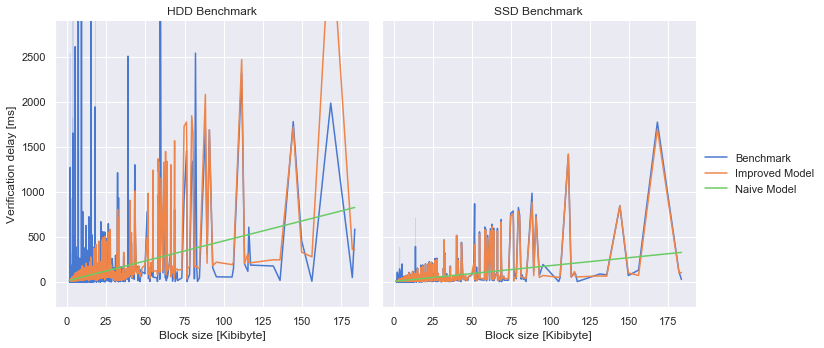

In [11]:
grid = sns.FacetGrid(d1, col="Type", height=5, hue="Model", palette=[color_primary, color_kv, color_kb])
grid = grid.map(sns.lineplot, "SIZE", "NS")
grid.set(ylim=(None, 2900))
grid.add_legend(title='')

grid.set_xlabels('Block size [Kibibyte]')
grid.set_ylabels('Verification delay [ms]')
grid.set_titles('{col_name} Benchmark')

if SAVE_FIGURES:
    grid.fig.savefig("KV_KB_Size.png", bbox_inches='tight', dpi=DPI)

In [12]:
model_error = estimates_reg.copy(deep=True)

def relative_error(real, predict):
    return (abs(real - predict) / real) * 100

model_error['KV_HDD_mae'] = model_error.apply(lambda row : (relative_error(row['BLOCK_NS_HDD'], row['KV_HDD'])), axis = 1) 
model_error['KV_SSD_mae'] = model_error.apply(lambda row : (relative_error(row['BLOCK_NS_SSD'], row['KV_SSD'])), axis = 1) 

model_error['KB_HDD_mae'] = model_error.apply(lambda row : (relative_error(row['BLOCK_NS_HDD'], row['KB_HDD'])), axis = 1) 
model_error['KB_SSD_mae'] = model_error.apply(lambda row : (relative_error(row['BLOCK_NS_SSD'], row['KB_SSD'])), axis = 1) 

model_error_ssd = pd.melt(model_error.rename(columns={'KV_SSD_mae': 'Improved Model', 'KB_SSD_mae': 'Naive Model'}), id_vars=['BLOCK', 'SIZE'], value_vars=['Improved Model', 'Naive Model'], var_name='Model', value_name='MAE')

model_error_hdd = pd.melt(model_error.rename(columns={'KV_HDD_mae': 'Improved Model', 'KB_HDD_mae': 'Naive Model'}), id_vars=['BLOCK', 'SIZE'], value_vars=['Improved Model', 'Naive Model'], var_name='Model', value_name='MAE')

#model_error_ssd["MAE"] = model_error_ssd["MAE"] / 1000000 # Convert to mss
model_error_ssd["SIZE"] = model_error_ssd["SIZE"] / 1024 # Convert to Kibibyte

#model_error_hdd["MAE"] = model_error_hdd["MAE"] / 1000000 # Convert to mss
model_error_hdd["SIZE"] = model_error_hdd["SIZE"] / 1024 # Convert to Kibibyte

In [13]:
model_error['KV_SSD_mae'].median()

31.1682492727424

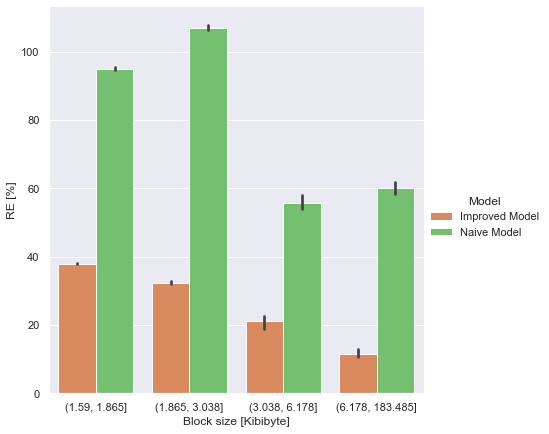

In [14]:
# Plot error in bins
from numpy import median

Q = 4
d1_bins = model_error_ssd.copy(deep=True)
d1_bins['SIZE_BINS'] = pd.qcut(d1_bins['SIZE'], Q)

g = sns.catplot(x="SIZE_BINS", 
                y="MAE",
                hue="Model",
                kind="bar",
                estimator=median,
                height=6,
                data=d1_bins,
                palette=[color_kv, color_kb]);

g.set(ylabel="RE [%]", xlabel="Block size [Kibibyte]")
g.fig.savefig("MAE.png", bbox_inches='tight', dpi=DPI)

In [15]:
# Compare models with real values
gridplotdata = estimates_reg.copy(deep=True)

gridplotdata["BLOCK_NS_SSD"] = gridplotdata["BLOCK_NS_SSD"] / 1000000 # 1000000 # Convert to ms
gridplotdata["KV_SSD"] = gridplotdata["KV_SSD"] / 1000000 # 1000000 # Convert to ms
gridplotdata["KB_SSD"] = gridplotdata["KB_SSD"] / 1000000 # 1000000 # Convert to ms

grid = sns.jointplot(data=gridplotdata, x='BLOCK_NS_SSD', y='KV_SSD', kind="reg", stat_func=r2_score, marginal_kws={'color': color_primary}, joint_kws={'scatter_kws':{'edgecolor':'white'}, 'line_kws':{'color': color_kv}})
#grid.ax_joint.set(ylim=(0, 100))
#grid.ax_joint.set(xlim=(0, 100))

grid.ax_joint.set_xlabel('Verification delay [ms]')
grid.ax_joint.set_ylabel('Estimated verification delay [ms]')

if SAVE_FIGURES:
    grid.fig.savefig("KV_R2.png", bbox_inches='tight', dpi=DPI)

TypeError: regplot() got an unexpected keyword argument 'stat_func'

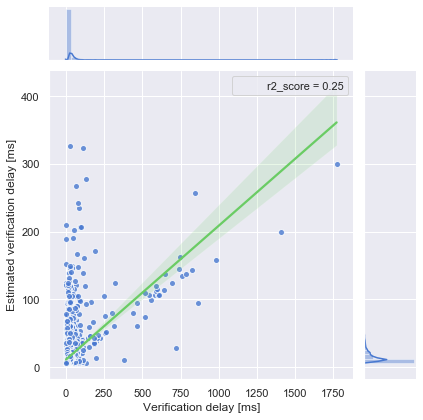

In [33]:
grid = sns.jointplot(data=gridplotdata, x='BLOCK_NS_SSD', y='KB_SSD', kind="reg", stat_func=r2_score, marginal_kws={'color': color_primary}, joint_kws={'scatter_kws':{'edgecolor':'white'} ,'line_kws':{'color': color_kb}})

grid.ax_joint.set_xlabel('Verification delay [ms]')
grid.ax_joint.set_ylabel('Estimated verification delay [ms]')

if SAVE_FIGURES:
    grid.fig.savefig("KB_R2.png", bbox_inches='tight', dpi=DPI)

In [34]:
# Plot per block
BLOCKS = 200

# Include block height
d1_block = estimates_reg.copy(deep=True)
tmp = blocks_info.copy(deep=True)
tmp = tmp.reset_index()
tmp = tmp.rename(columns = {'index':'height'})
d1_block = d1_block.merge(tmp, how='inner', left_on="BLOCK", right_on="BLOCK")
d1_block = d1_block.sort_values(by=['height']).tail(BLOCKS)

# Preapre plot data
d1_block = d1_block.rename(columns={'BLOCK_NS_SSD': 'Benchmark', 'KB_SSD': 'Naive Model', 'KV_SSD': 'Improved Model'})
kb_gridplotdata = pd.melt(d1_block, id_vars=['height'], value_vars=['Benchmark', 'Naive Model'], var_name="Model")
kv_gridplotdata = pd.melt(d1_block, id_vars=['height'], value_vars=['Benchmark', 'Improved Model'], var_name="Model")

kb_gridplotdata["value"] = kb_gridplotdata["value"] / 1000000 # 1000000 # Convert to ms
kv_gridplotdata["value"] = kv_gridplotdata["value"] / 1000000 # 1000000 # Convert to ms

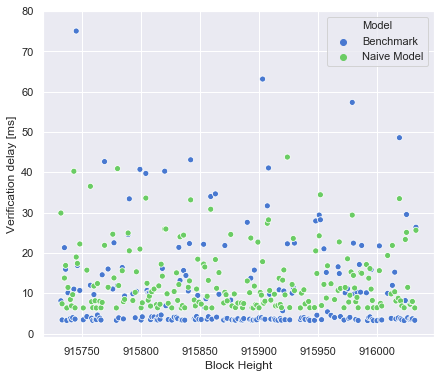

In [35]:
# KB plot
grid = sns.scatterplot(data=kb_gridplotdata, x='height', y='value', hue="Model", palette=[color_primary, color_kb])
grid.set(xlabel='Block Height', ylabel='Verification delay [ms]')
grid.get_figure().set_size_inches(7, 6)
grid.set(ylim=(None, 80))

if SAVE_FIGURES:
    grid.get_figure().savefig("Block_KB.png", bbox_inches='tight', dpi=DPI)

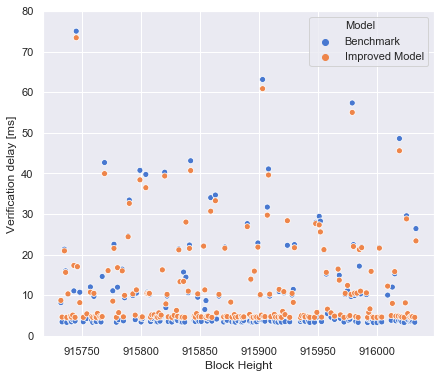

In [36]:
# KV plot
grid = sns.scatterplot(data=kv_gridplotdata, x='height', y='value', hue="Model", palette=[color_primary, color_kv])
grid.set(xlabel='Block Height', ylabel='Verification delay [ms]')
grid.get_figure().set_size_inches(7, 6)
grid.set(ylim=(None, 80))

if SAVE_FIGURES:
    grid.get_figure().savefig("Block_KV.png", bbox_inches='tight', dpi=DPI)

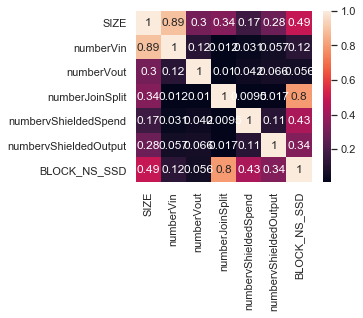

In [27]:
#Correlation
corrMatrix = blocks[["SIZE", "numberVin", "numberVout", "numberJoinSplit", "numbervShieldedSpend", "numbervShieldedOutput", "BLOCK_NS_SSD"]].corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [28]:
abs(corrMatrix['BLOCK_NS_SSD'].sort_values())

numberVout               0.056160
numberVin                0.124236
numbervShieldedOutput    0.335796
numbervShieldedSpend     0.430726
SIZE                     0.487774
numberJoinSplit          0.795232
BLOCK_NS_SSD             1.000000
Name: BLOCK_NS_SSD, dtype: float64